# IR Approx
This notebook prototypes the construction of IIR filter kernels to approximate FIR impulse responses using machine learning

## Step 1: Procure an impulse response from [ToneHunt.org](https://tonehunt.org/)

--2025-02-26 23:07:51--  https://aekspllirhgukfwncmhb.supabase.co/storage/v1/object/public/models/0.7209741631584776.zip
Resolving aekspllirhgukfwncmhb.supabase.co (aekspllirhgukfwncmhb.supabase.co)... 172.64.149.246, 104.18.38.10
Connecting to aekspllirhgukfwncmhb.supabase.co (aekspllirhgukfwncmhb.supabase.co)|172.64.149.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34291 (33K) [application/octet-stream]
Saving to: ‘0.7209741631584776.zip’

0.7209741631584776. 100%[===================>]  33.49K  --.-KB/s    in 0.006s  

2025-02-26 23:07:52 (5.85 MB/s) - ‘0.7209741631584776.zip’ saved [34291/34291]

Archive:  0.7209741631584776.zip
  inflating: Mesa_OS_4x12_57_m160.wav  


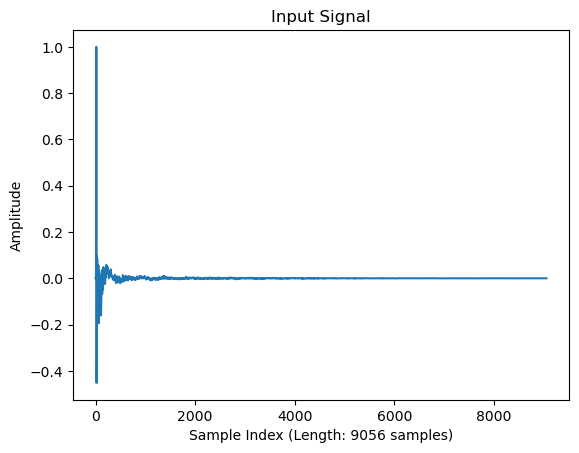

In [21]:
# Get file and load into notebook (TODO: Make Interactive)
from scipy.io import wavfile
!wget https://aekspllirhgukfwncmhb.supabase.co/storage/v1/object/public/models/0.7209741631584776.zip
!unzip 0.7209741631584776.zip
!rm 0.7209741631584776.zip
!mv Mesa_OS_4x12_57_m160.wav input.wav
input_rate, input_signal = wavfile.read('input.wav')

# Display and sonify the IR
import matplotlib.pyplot as plt
from IPython.display import Audio
plt.plot(input_signal)
plt.xlabel('Sample Index' + ' (Length: ' + str(len(input_signal)) + ' samples)')
plt.ylabel('Amplitude')
plt.title('Input Signal')
plt.show()
Audio(data = input_signal, rate = input_rate)

## Step 2: Pass Audio to Trainer

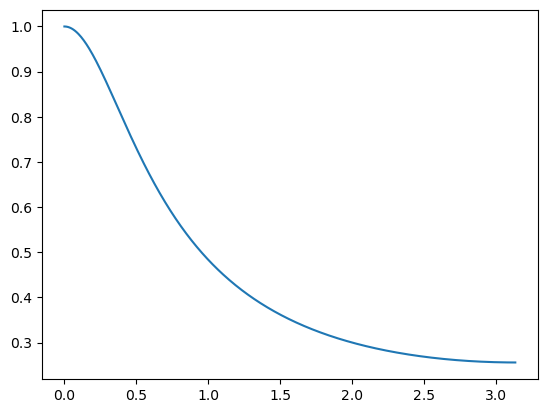

In [25]:
# define a one-pole filter and apply it to the signal
# TODO: SVF would be more fun to play with
# TODO: Train on input.wav instead
from scipy.signal import freqz

# Nice one-pole filter class from Karl Yerkes
class OnePole:

  def __init__(self):
    self.b0 = 1
    self.a1 = 0
    self.y1 = 0

  def process(self, x0):
    t = x0 * self.b0 - self.y1 * self.a1
    self.y1 = t
    return t

  def lowpass(self, f0, samplerate):
    self.a1 = -np.exp(-2.0 * np.pi * f0 / samplerate)
    self.b0 = 1.0 + self.a1

  def highpass(self, f0, samplerate):
    self.a1 = np.exp(-2.0 * np.pi * f0 / samplerate)
    self.b0 = 1.0 - self.a1

  def show(self):
    print("output = {} * signal + {} * output".format(self.b0, self.a1))

  def freqz(self):
    return freqz([self.b0], [1, self.a1])

# show one-pole filter response
filter = OnePole()
filter.lowpass(4000, 48000)
w, h = filter.freqz()
plt.plot(w, abs(h))
pass


Final error: 0.0024572448142095235
Epochs: 198
Training time: 26.74 seconds


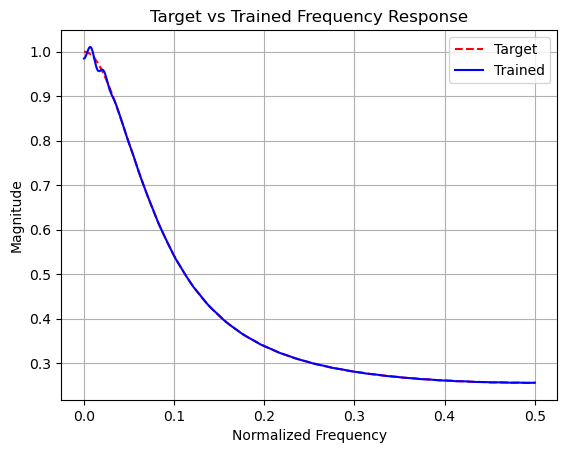

In [29]:
# train on the one-pole's impulse response
size = 1028

# init test_signal
test_signal = np.zeros(size)
test_signal[0] = 1
for i in range(0, size):
    test_signal[i] = filter.process(test_signal[i])

# train
from main import Trainer
test_signal = np.fft.fft(test_signal, n=size)
trainer = Trainer(fft_size=size)
trainer(test_signal.real[:size//2])
pass

## Step 3: Optimize IIR kernels of increasing size until sufficient accuracy is reached

## Step 4: Output C++ Header Containing the filter object